In [73]:
import numpy as np
import pandas as pd
import os

# Download MITBIH dataset

In [74]:
!wget https://github.com/psudh/cds-signal-processing/raw/main/data/mitbih_test.csv

--2020-10-06 05:26:42--  https://github.com/psudh/cds-signal-processing/raw/main/data/mitbih_test.csv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/psudh/cds-signal-processing/main/data/mitbih_test.csv [following]
--2020-10-06 05:26:42--  https://raw.githubusercontent.com/psudh/cds-signal-processing/main/data/mitbih_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102892400 (98M) [text/plain]
Saving to: ‘mitbih_test.csv.2’

mitbih_test.csv.2   100%[===================>]  98.12M   209MB/s    in 0.5s    

2020-10-06 05:26:43 (209 MB/s) - ‘mitbih_test.csv.2’ saved [102892400/102892400]



In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [50]:
# import dataset
df = pd.read_csv("mitbih_test.csv", header = None)
train_df, test_df = train_test_split(df, test_size=0.2)

In [51]:
# Value of each class
train_df[187].value_counts()

0.0    14482
4.0     1276
2.0     1171
1.0      454
3.0      130
Name: 187, dtype: int64

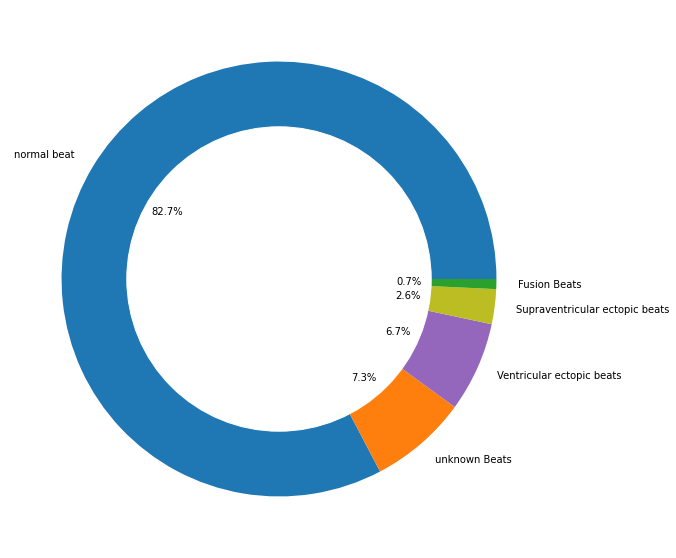

In [52]:
# Representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, 
        labels=['normal beat',
                'unknown Beats',
                'Ventricular ectopic beats',
                'Supraventricular ectopic beats',
                'Fusion Beats'], 
        colors=['tab:blue',
                'tab:orange',
                'tab:purple',
                'tab:olive',
                'tab:green'],
        autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Resampling for balacing the dataset

In [53]:
from sklearn.utils import resample

df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=2000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=2000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=2000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=2000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=2000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

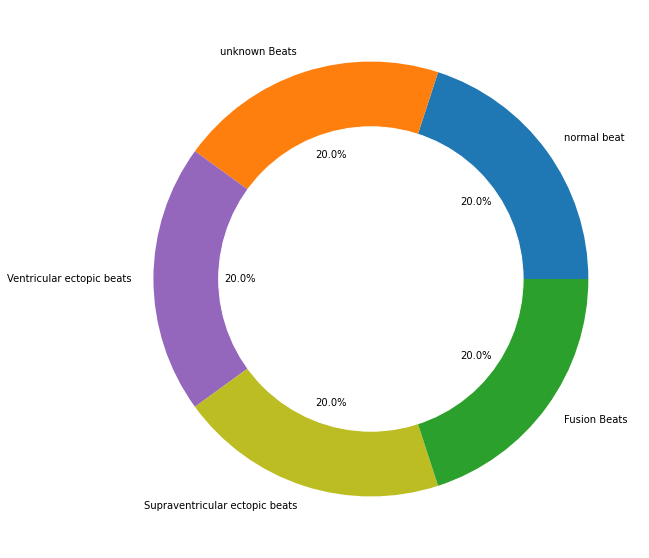

In [54]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, 
        labels=['normal beat',
                'unknown Beats',
                'Ventricular ectopic beats',
                'Supraventricular ectopic beats',
                'Fusion Beats'], 
        colors=['tab:blue',
                'tab:orange',
                'tab:purple',
                'tab:olive',
                'tab:green'],
        autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Classes

In [55]:
# Randomly sampling from each class
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [56]:
# Peek on classes
classes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
3123,1.000000,0.848797,0.412371,0.189003,0.109966,0.072165,0.024055,0.000000,0.010309,0.020619,0.013746,0.027491,0.020619,0.017182,0.027491,0.030928,0.030928,0.030928,0.037801,0.048110,0.034364,0.054983,0.037801,0.037801,0.017182,0.034364,0.061856,0.079038,0.099656,0.109966,0.113402,0.123711,0.134021,0.137457,0.127148,0.137457,0.134021,0.127148,0.123711,0.120275,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18604,0.952830,0.688679,0.259434,0.122642,0.117925,0.099057,0.117925,0.146226,0.141509,0.155660,0.183962,0.179245,0.160377,0.207547,0.216981,0.207547,0.221698,0.221698,0.245283,0.254717,0.259434,0.250000,0.297170,0.297170,0.287736,0.306604,0.344340,0.330189,0.334906,0.349057,0.377358,0.349057,0.344340,0.382075,0.358491,0.311321,0.311321,0.311321,0.250000,0.202830,...,0.240566,0.245283,0.268868,0.287736,0.268868,0.278302,0.334906,0.320755,0.29717,0.334906,0.339623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19326,0.748737,0.661616,0.388889,0.162879,0.066919,0.010101,0.000000,0.045455,0.118687,0.188131,0.244949,0.321970,0.385101,0.420455,0.487374,0.578283,0.602273,0.593434,0.590909,0.592172,0.598485,0.612374,0.621212,0.630050,0.642677,0.654040,0.657828,0.670455,0.690657,0.707071,0.722222,0.724747,0.732323,0.732323,0.723485,0.699495,0.681818,0.659091,0.628788,0.597222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
20130,1.000000,0.900794,0.462302,0.208333,0.170635,0.156746,0.146825,0.130952,0.136905,0.134921,0.144841,0.134921,0.152778,0.140873,0.144841,0.144841,0.158730,0.156746,0.156746,0.152778,0.180556,0.178571,0.198413,0.198413,0.218254,0.232143,0.250000,0.250000,0.251984,0.236111,0.218254,0.202381,0.184524,0.166667,0.160714,0.152778,0.156746,0.152778,0.156746,0.146825,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
20370,0.940041,0.886179,0.823171,0.765244,0.673781,0.556911,0.424797,0.316057,0.232724,0.171748,0.137195,0.074187,0.023374,0.000000,0.096545,0.197154,0.256098,0.281504,0.303862,0.326219,0.375000,0.419715,0.443089,0.488821,0.523374,0.553862,0.559959,0.573171,0.583333,0.591463,0.601626,0.614837,0.631098,0.649390,0.665650,0.684959,0.706301,0.716463,0.734756,0.742886,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


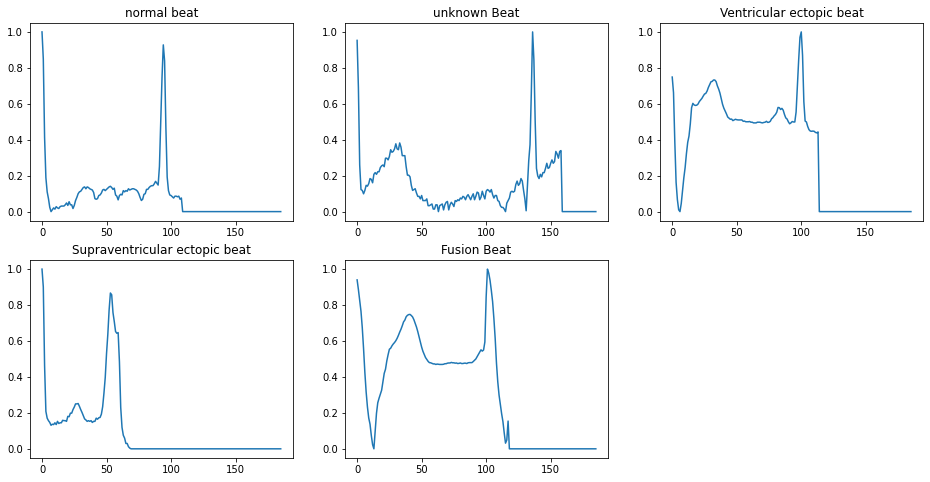

In [57]:
# plotting classes ECG
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)  
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)  
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)  
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

# Signal heatmap

In [58]:
def plot_hist(class_number,size,min_):
    # get the class data
    img=train_df.loc[train_df[187]==class_number].values
    # crop it
    img=img[:,min_:size]
    # creates a continous steam of data
    img_flatten=img.flatten()
    
    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

130000
130000


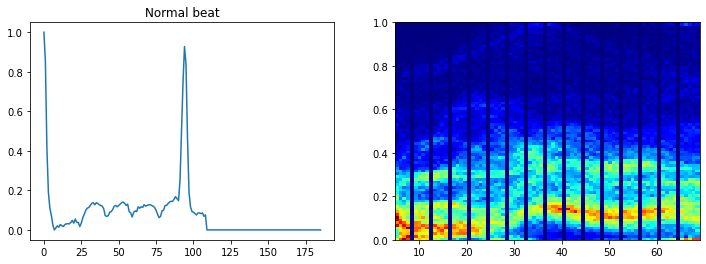

In [59]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)

90000
90000


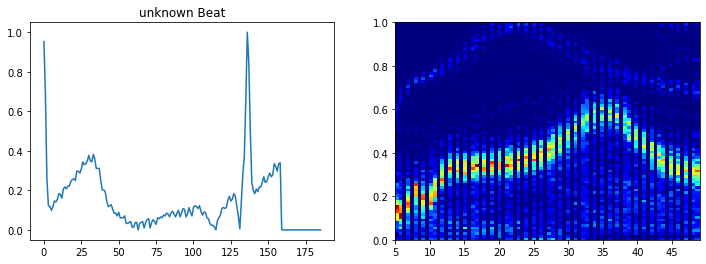

In [60]:
# unknown
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
plt.subplot(1, 2, 2)  
plot_hist(1,50,5)

60000
60000


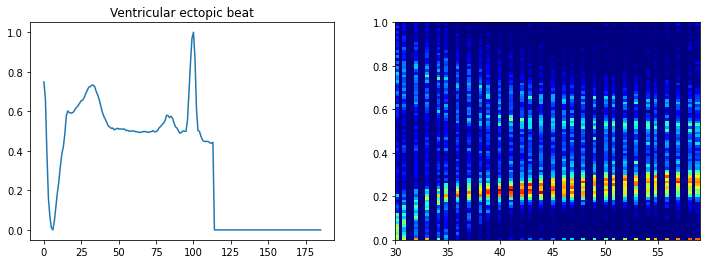

In [61]:
# veb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(2,60,30)

70000
70000


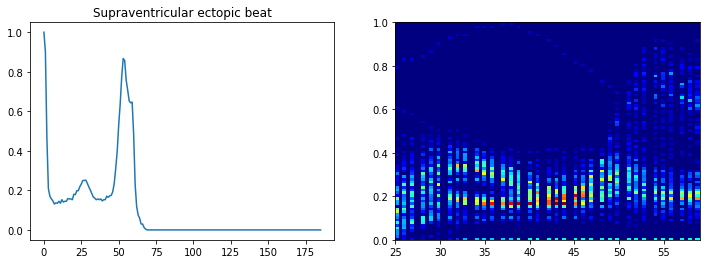

In [62]:
# seb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1) 
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(3,60,25)

64000
64000


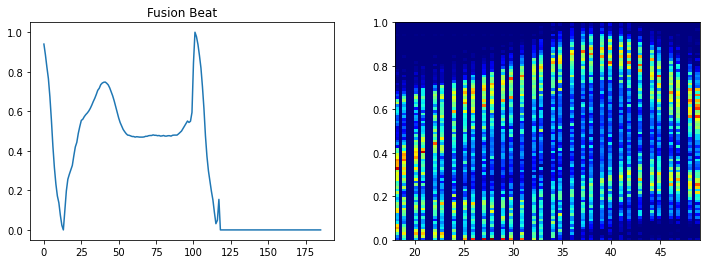

In [63]:
# fusion
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)   
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
plt.subplot(1, 2, 2) 
plot_hist(4,50,18)

# Pretreat

In [64]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

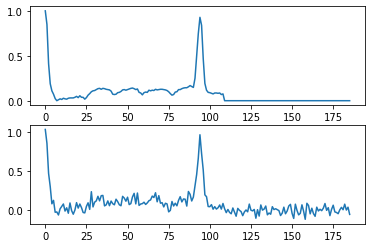

In [65]:
tempo=classes.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [66]:
target_train = train_df[187]
target_test  = test_df[187]
y_train = to_categorical(target_train)
y_test  = to_categorical(target_test)

In [67]:
X_train = train_df.iloc[:,:186].values
X_test  = test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test  = X_test.reshape(len(X_test), X_test.shape[1],1)

In [68]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [69]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [70]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/5
313/313 [==============================] - 2s 8ms/step - loss: 0.3998 - accuracy: 0.8559 - val_loss: 2.6276 - val_accuracy: 0.0649
Epoch 2/5
313/313 [==============================] - 2s 7ms/step - loss: 0.1882 - accuracy: 0.9332 - val_loss: 0.5793 - val_accuracy: 0.7805
Epoch 3/5
313/313 [==============================] - 2s 6ms/step - loss: 0.1166 - accuracy: 0.9617 - val_loss: 0.3227 - val_accuracy: 0.8826
Epoch 4/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0872 - accuracy: 0.9716 - val_loss: 0.2659 - val_accuracy: 0.9112
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0614 - accuracy: 0.9803 - val_loss: 0.2020 - val_accuracy: 0.9409


Accuracy: 94.09%


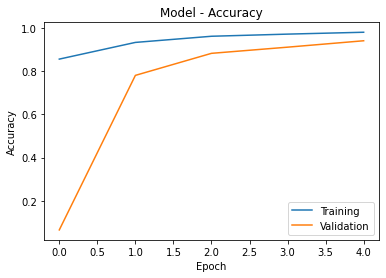

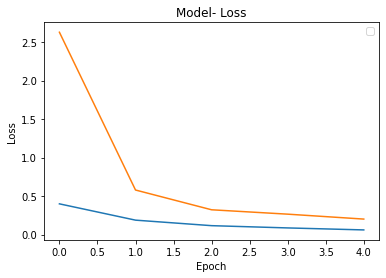

In [71]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


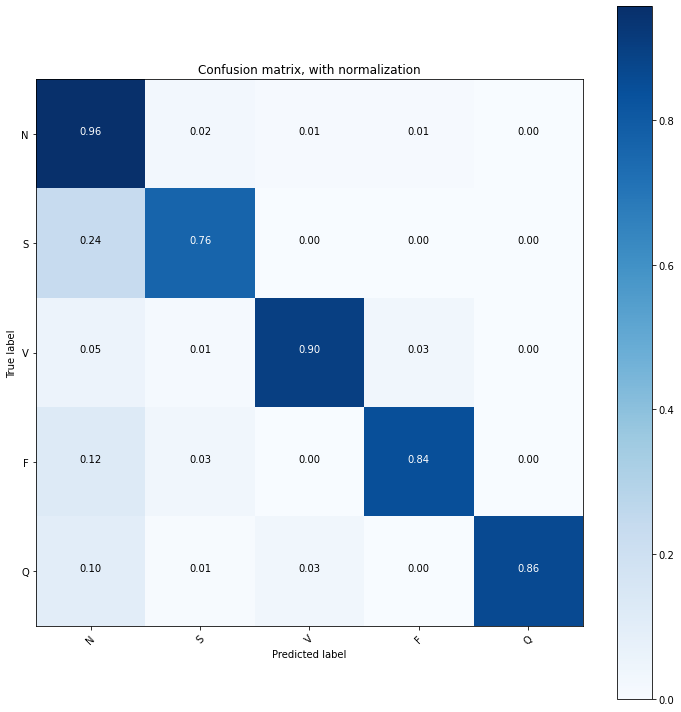

In [72]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()